# Sparkify Project Workspace

In [1]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession, Window

import pyspark.sql.functions as F

from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType, DoubleType, LongType

%matplotlib inline
import matplotlib.pyplot as plt

import datetime

from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier

# for model evaluation
from sklearn.metrics import f1_score, recall_score, precision_score

# for Principal Component Analysis
from pyspark.ml.feature import PCA

# import IBM Watson Studio Lib to save data and models
from project_lib import Project
project = Project(sc,"0f767c58-a6da-4225-a3a9-1526012f97c0", "p-3cdd7b2b8037c9f4b97413e96fdcb72741dcfb9d")

# import time to pause program execution during model training
import time 

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191229142350-0001
KERNEL_ID = 5f9bea9b-baf6-4ae9-919b-b14ca1d17425


# Start SparkSession and load dataset

In [2]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-f92cad2e-dfc4-460b-b6da-6823a8a1941c',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'Z6Nf1UKJ_bt7cKZvw_EiAHYIoYhtcCpwOmkJJT3Slxy_'
}

configuration_name = 'os_1647a8daaebd47249daa2481cc9164f0_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

user_log = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-2exnp1jnopynlt'))
user_log.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
import pixiedust

Pixiedust database opened successfully


In [4]:
pixiedust.optOut()

Pixiedust will not collect anonymous install statistics.


In [5]:
start_time = datetime.datetime.now()

# Explore and clean data set

In [ ]:
# Peek at dataset
display(user_log)

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,CSA,ts_ts,ts_hour,ts_date,downgraded,upgraded,advert_shown,thumps_down,thumps_up,friend_added,song_added,gender_bin,level_bin
None,Logged In,Sawyer,M,79,Larson,nan,free,"Houston-The Woodlands-Sugar Land, TX",GET,Help,1538069638000,97,None,200,1538352947000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",98,0,TX,2018-10-01 00:15:47,0,2018-10-01 00:00:00,0,0,0,0,0,0,0,1,0
Bob James and David Sanborn,Logged In,Gianna,F,31,Campos,274.6771,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Maputo (Edit Version),200,1538353579000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246,0,AL,2018-10-01 00:26:19,0,2018-10-01 00:00:00,0,0,0,0,0,0,0,0,1
Beirut,Logged In,Payton,F,94,Campbell,213.68118,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1529027541000,38,La Llorona,200,1538353937000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",39,0,CA,2018-10-01 00:32:17,0,2018-10-01 00:00:00,0,0,0,0,0,0,0,0,0
None,Logged In,Joel,M,17,Thomas,nan,free,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Add Friend,1534248752000,485,None,307,1538358281000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",273,0,NY-NJ-PA,2018-10-01 01:44:41,1,2018-10-01 00:00:00,0,0,0,0,0,1,0,1,0
Metallica,Logged In,Anthony,M,2,Reed,387.02975,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1534823030000,511,Welcome Home (Sanitarium),200,1538359083000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",166,0,FL,2018-10-01 01:58:03,1,2018-10-01 00:00:00,0,0,0,0,0,0,0,1,0
Aventura,Logged In,Carter,M,2,Cook,516.38812,paid,"Chicago-Naperville-Elgin, IL-IN-WI",PUT,NextSong,1522793334000,287,La Guerra,200,1538359362000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",288,0,IL-IN-WI,2018-10-01 02:02:42,2,2018-10-01 00:00:00,0,0,0,0,0,0,0,1,1
DJ Khaled,Logged In,Maverick,M,222,Santiago,227.082,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop Dogg & Rick Ross),200,1538359711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179,0,FL,2018-10-01 02:08:31,2,2018-10-01 00:00:00,0,0,0,0,0,0,0,1,1
Luther Vandross,Logged In,Anthony,M,19,Reed,372.74077,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1534823030000,511,The Glow Of Love,200,1538361807000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",166,0,FL,2018-10-01 02:43:27,2,2018-10-01 00:00:00,0,0,0,0,0,0,0,1,0
None,Logged In,Gianna,F,82,Campos,nan,paid,"Mobile, AL",PUT,Thumbs Up,1535931018000,245,None,307,1538363212000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246,0,AL,2018-10-01 03:06:52,3,2018-10-01 00:00:00,0,0,0,0,1,0,0,0,1
Roudoudou,Logged In,Sofia,F,318,Gordon,267.93751,paid,"Rochester, MN",PUT,NextSong,1533175710000,162,Zoom Zoom,200,1538363565000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36""",163,0,MN,2018-10-01 03:12:45,3,2018-10-01 00:00:00,0,0,0,0,0,0,0,0,1


In [7]:
numerical_columns = [
 'itemInSession',

 'registration',
 'sessionId',
 'status',
 'ts']

categorical_columns = ['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [8]:
user_log.select(numerical_columns).describe().toPandas()

,summary,itemInSession,registration,sessionId,status,ts
0,count,543705,528005,543705,543705,543705
1,mean,107.30629109535502,1.535523414862437E12,2040.8143533717732,210.01829116892432,1.5409645412098003E12
2,stddev,116.72350849188074,3.0787254929957166E9,1434.338931078271,31.471919021567537,1.4820571449105084E9
3,min,0,1509854193000,1,200,1538352011000
4,max,1005,1543073874000,4808,404,1543622466000


In [9]:
for column in categorical_columns:
    print(user_log.select(F.countDistinct(column).alias(column + " : distinct values")).show())

+------------------------+
|artist : distinct values|
+------------------------+
|                   21247|
+------------------------+

None
+----------------------+
|auth : distinct values|
+----------------------+
|                     4|
+----------------------+

None
+---------------------------+
|firstName : distinct values|
+---------------------------+
|                        345|
+---------------------------+

None
+------------------------+
|gender : distinct values|
+------------------------+
|                       2|
+------------------------+

None
+--------------------------+
|lastName : distinct values|
+--------------------------+
|                       275|
+--------------------------+

None
+-----------------------+
|level : distinct values|
+-----------------------+
|                      2|
+-----------------------+

None
+--------------------------+
|location : distinct values|
+--------------------------+
|                       192|
+--------------------------+

In [10]:
# further analysis of relationship between page and status...
user_log.groupBy(["status", "method", "page"]).count().orderBy("status", "method", "count").show()

+------+------+--------------------+------+
|status|method|                page| count|
+------+------+--------------------+------+
|   200|   GET|            Register|    11|
|   200|   GET|Cancellation Conf...|    99|
|   200|   GET|             Upgrade|   968|
|   200|   GET|               About|  1855|
|   200|   GET|            Settings|  2964|
|   200|   GET|                Help|  3150|
|   200|   GET|           Downgrade|  3811|
|   200|   GET|         Roll Advert|  7773|
|   200|   GET|                Home| 27412|
|   200|   PUT|     Add to Playlist| 12349|
|   200|   PUT|            NextSong|432877|
|   307|   PUT| Submit Registration|     4|
|   307|   PUT|              Cancel|    99|
|   307|   PUT|    Submit Downgrade|   117|
|   307|   PUT|      Submit Upgrade|   287|
|   307|   PUT|       Save Settings|   585|
|   307|   PUT|         Thumbs Down|  4911|
|   307|   PUT|              Logout|  5990|
|   307|   PUT|               Login|  6011|
|   307|   PUT|          Add Fri

In [11]:
# detailled analysis of feature "userAgent"
pd_df = user_log.groupBy("userAgent").count().orderBy("count").toPandas()
print(pd_df["userAgent"].tolist())
pd_df["count"].describe()

['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14"', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:30.0) Gecko/20100101 Firefox/30.0', '"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', 'Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:30.0) Gecko/20100101 Firefox/30.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.74.9 (KHTML, like Gecko) Version/7.0.2 Safari/537.74.9"', '"Mozilla/5.

count       72.000000
mean      7551.458333
std       9805.527044
min        245.000000
25%       1802.250000
50%       3546.000000
75%       9839.500000
max      46082.000000
Name: count, dtype: float64

In [12]:
# print missing values depending on column "auth" value
auth_values = user_log.select("auth").distinct().rdd.map(lambda r: r[0]).collect()
for value in auth_values:
    print("null values in rows with auth value {}:".format(value))
    value_df = user_log.filter(user_log["auth"] == value)
    missing_value_columns = ['artist',
                             'firstName',
                             'gender',
                             'lastName',
                             'length',
                             'location',
                             'registration',
                             'song',
                             'userAgent',
                             'userId',
                            ]
    for column in missing_value_columns:
        print("column {} : {}".format(column, value_df.filter(value_df[column].isNull()).count()))

null values in rows with auth value Logged Out:
column artist : 15606
column firstName : 15606
column gender : 15606
column lastName : 15606
column length : 15606
column location : 15606
column registration : 15606
column song : 15606
column userAgent : 15606
column userId : 0
null values in rows with auth value Cancelled:
column artist : 99
column firstName : 0
column gender : 0
column lastName : 0
column length : 99
column location : 0
column registration : 0
column song : 99
column userAgent : 0
column userId : 0
null values in rows with auth value Guest:
column artist : 94
column firstName : 94
column gender : 94
column lastName : 94
column length : 94
column location : 94
column registration : 94
column song : 94
column userAgent : 94
column userId : 0
null values in rows with auth value Logged In:
column artist : 95029
column firstName : 0
column gender : 0
column lastName : 0
column length : 95029
column location : 0
column registration : 0
column song : 95029
column userAgent :

## Remove values where "auth" value is either "Guest" or "Logged Out" since userId is missing

In [13]:
print("Rows in dataset before auth values Guest and Logged Out are removed: ", user_log.count())

# remove values where "auth" value is either "Guest" or "Logged Out" since userId is missing
user_log = user_log.filter(user_log["auth"].isin(*["Guest", "Logged Out"]) == False)

print("Rows in dataset before auth values Guest and Logged Out are removed: ", user_log.count())

Rows in dataset before auth values Guest and Logged Out are removed:  543705
Rows in dataset before auth values Guest and Logged Out are removed:  528005


# Exploratory Data Analysis
## Define feature "churn"

Distinct users in dataset: 448
Value counts of churn over all userId's:
0    448
1     99
Name: churn, dtype: int64


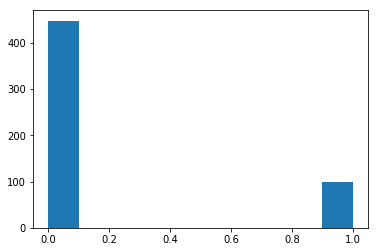

In [14]:
flag_churn_event = F.udf(lambda page: 1 if page == "Cancellation Confirmation" else 0, IntegerType())
user_log = user_log.withColumn("churn", flag_churn_event("page"))

# analyze churn per userId
pd_df = user_log.select("userId", "churn").dropDuplicates().toPandas()
print("Distinct users in dataset: {}".format(pd_df["userId"].nunique()))
print("Value counts of churn over all userId's:")
print(pd_df["churn"].value_counts())
plt.hist(pd_df["churn"])
plt.show()

## Explore Data

### "location": analyse user locations and CSA (Combined Statistical Areas)

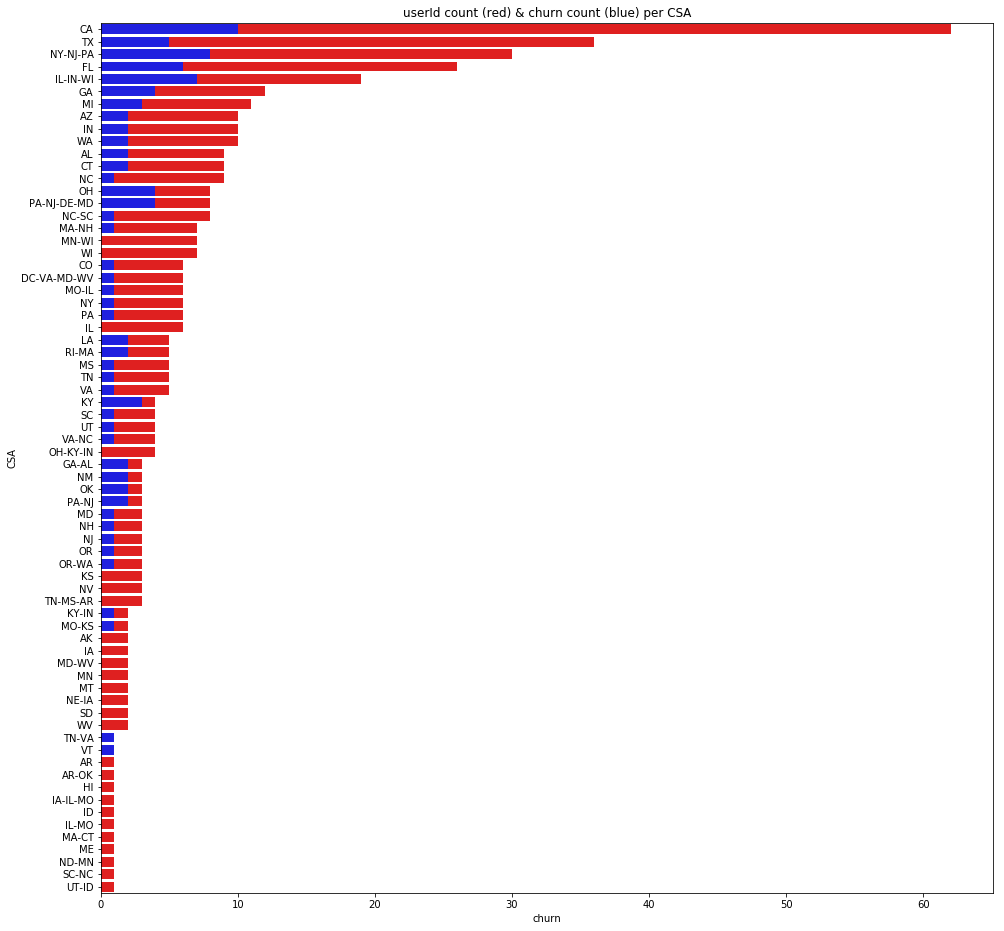

In [15]:
# create new feature CSA (Combined Statistical Areas) from location 
get_csa = F.split(user_log["location"], ", ")
user_log = user_log.withColumn("CSA", get_csa.getItem(1))

# analyze CSA
pd_user_csa_churn = user_log.select("userId", "CSA", "churn").dropDuplicates().groupBy("userId", "CSA").agg(F.sum("churn").alias("churn")).toPandas()

pd_csa_analysis = pd_user_csa_churn.groupby("CSA", as_index=False).agg({"userId":"count", "churn": "sum"}).sort_values(by=["userId", "churn"], ascending = False)

plt.figure(figsize=(16, 16))
sns.barplot(x="userId", y="CSA" , data=pd_csa_analysis, color = "red");
sns.barplot(x="churn", y="CSA" , data=pd_csa_analysis, color = "blue").set_title("userId count (red) & churn count (blue) per CSA");

### Convert to timestamp "ts" time/date

In [16]:
def convert_ts_to_datetime(df, column):
    get_datetime = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp/1000).isoformat())
    df = df.withColumn(column + "_ts", get_datetime(df[column]).cast(TimestampType()))
    return df

# create new feature with Spark Timestamp data type
user_log = convert_ts_to_datetime(user_log, "ts")

In [17]:
# analyze min and max timestamp data in set
min_date, max_date = user_log.select(F.min("ts_ts"), F.max("ts_ts")).first()
print("Minimum and Maximum timestamp data:")
min_date, max_date

Minimum and Maximum timestamp data:


(datetime.datetime(2018, 10, 1, 0, 0, 11),
 datetime.datetime(2018, 12, 1, 0, 1, 6))

Analyze log data over time:


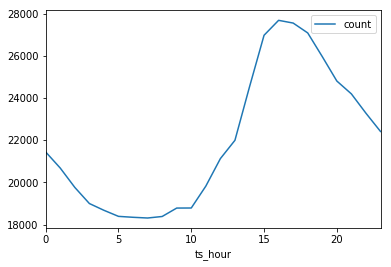

In [18]:
# get new features day and hour from ts
user_log = user_log.withColumn("ts_hour", F.hour("ts_ts"))
user_log = user_log.withColumn("ts_date", F.to_date("ts_ts"))

print("Analyze log data over time:")
#pd_df = user_log.select(hour("ts_ts").alias("hour")).groupBy("hour").count().orderBy("hour").toPandas()
pd_df = user_log.select("ts_hour").groupBy("ts_hour").count().orderBy("ts_hour").toPandas()
pd_df.plot.line(x="ts_hour", y="count");

### Features from "page" value

In [19]:
def create_page_value_feature(df, page_value, col_name):
    '''
    ARGS
    df: Spark dataframe
    page_value: categorical value in column "page" of df
    col_name: column name of new feature that is added to df
    
    OUTPUT: Spark dataframe with new column from page value
    
    Function that creates a new feature from a certain value of feature "page"
    '''
    flag_page_value_event = F.udf(lambda page: 1 if page == page_value else 0, IntegerType())
    return df.withColumn(col_name, flag_page_value_event("page"))

# dictionary for page values and corresponding new features
page_value_feature_dict = {"Submit Downgrade" : "downgraded",
                           "Submit Upgrade" : "upgraded",
                           "Roll Advert" : "advert_shown",
                           "Thumbs Down": "thumps_down",
                           "Thumbs Up": "thumps_up",
                           "Add Friend": "friend_added",
                           "Add to Playlist" : "song_added"
                          }

for page_value in page_value_feature_dict.keys():
    column_name = page_value_feature_dict[page_value]
    user_log =  create_page_value_feature(user_log, page_value, column_name)

# Feature Engineering

## Create new dataframe for features per userId

In [20]:
# create new df for features
all_users_collect = user_log.select("userId").filter(user_log["userId"]!="").distinct().collect()
all_users = set([int(row["userId"]) for row in all_users_collect])
features_df = spark.createDataFrame(all_users, IntegerType()).withColumnRenamed('value', 'userId')

## Encode label "churned users"

In [21]:
# create feature "label" for churned users
churned_users_collect = user_log.select("userId").filter(user_log["churn"]==1).collect()
churned_users = set([int(row["userId"]) for row in churned_users_collect])
get_churn = F.udf(lambda user: 1 if user in churned_users else 0, IntegerType())
features_df = features_df.withColumn("label", get_churn("userId"))

## Encode binary features "gender", "level"

### Encode "gender"
- gender value "M" = value 1
- gender value "F" = value 0

### Encode "level"
- level value "paid" = value 1
- level value "free" = value 0

In [22]:
# one hot encode gender in original df
one_hot_encode_gender = F.udf(lambda gender: 1 if gender == "M" else 0, IntegerType())
user_log = user_log.withColumn("gender_bin", one_hot_encode_gender("gender"))

# join binary gender on userId in features df
user_gender_selection =  user_log.select(["userId", "gender_bin"]).dropDuplicates(subset=['userId'])
features_df = features_df.join(user_gender_selection, "userId")

# one hot encode level in original df
one_hot_encode_level = F.udf(lambda level: 1 if level == "paid" else 0, IntegerType())
user_log = user_log.withColumn("level_bin", one_hot_encode_level("level"))

# get last state of level for each userId
user_level_selection =  user_log\
.select(["userId", "level_bin", "ts"])\
.orderBy("ts", ascending=False)\
.dropDuplicates(subset=['userId'])\
.drop("ts")

# join binary gender on userId in features df
features_df = features_df.join(user_level_selection, "userId")

## Encode non-binary page view features
* encode count of page view features per userId
* page view features to be included: 
['downgraded',
 'upgraded',
 'advert_shown',
 'thumps_down',
 'thumps_up',
 'friend_added',
 'song_added']

In [23]:
page_features_count = user_log.groupBy("userId").sum('downgraded', 'upgraded',
 'advert_shown',
 'thumps_down',
 'thumps_up',
 'friend_added',
 'song_added')
features_df = features_df.join(page_features_count, "userId", how="left")

## Encode non-binary features related to service usage
* "song_count": songs per user
* "days_since_reg": days from registration until latest user timestamp of a user
* "session_time_seconds": accumulated session time per userId in seconds

In [24]:
# create new feature "song_count" in features_df
song_count = user_log.groupBy("userId").agg(F.count("song").alias("song_count")).orderBy("song_count", ascending=False)
features_df = features_df.join(song_count, "userId", how="left")

# create new feature "days_since_reg" in features_df
# create new features in timestamp format from features "registration"
reg_df=user_log.select("userId", "registration").filter(user_log["registration"].isNotNull()).distinct()
reg_df = convert_ts_to_datetime(reg_df, "registration")
reg_df = reg_df.withColumn("reg_date", F.to_date("registration_ts"))

# calculate difference between last user timestamp date and registration date
last_user_ts = user_log.groupBy("userId").agg(F.max("ts_date").alias("last_user_ts_date"))
reg_df = reg_df.join(last_user_ts, "userId", how="left")
reg_df = reg_df.withColumn("days_since_reg", F.datediff("last_user_ts_date", "reg_date"))

# add feature "days_since_reg" to features_df
features_df = features_df.join(reg_df.select("userId", "days_since_reg"), "userId", how="left")

# get new feature for accumulated session time per userId
user_session_min_ts = user_log.groupBy("userId", "sessionID").agg(F.min("ts")).orderBy("userId", "sessionID")
user_session_max_ts = user_log.groupBy("userId", "sessionID").agg(F.max("ts")).orderBy("userId", "sessionID")
user_session_max_ts = user_session_max_ts.join(user_session_min_ts, ["userId", "sessionID"])
user_session_max_ts = user_session_max_ts.withColumn("session_time_seconds", ((user_session_max_ts["max(ts)"]-user_session_max_ts["min(ts)"])/1000).cast(LongType()))

# calculate total session time per user
total_user_session_time = user_session_max_ts.groupBy("userId").agg(F.sum("session_time_seconds").alias("total_session_time_sec"))

# add feature "session_time_seconds" to features_df
features_df = features_df.join(total_user_session_time, "userId", how="left")

## Explore features with regards to churn

In [ ]:
display(features_df)

userId,label,gender_bin,level_bin,sum(downgraded),sum(upgraded),sum(advert_shown),sum(thumps_down),sum(thumps_up),sum(friend_added),sum(song_added),song_count,days_since_reg,total_session_time_sec,sum(downgraded)_scaled,sum(upgraded)_scaled,sum(advert_shown)_scaled,sum(thumps_down)_scaled,sum(thumps_up)_scaled,sum(friend_added)_scaled,sum(song_added)_scaled,song_count_scaled,days_since_reg_scaled,total_session_time_sec_scaled,features,pcaFeatures
300042,0,1,1,0,1,12,19,121,19,41,1397,62,346937,0.0,0.333,0.064,0.237,0.239,0.12,0.165,0.171,0.159,0.173,"[1.0,1.0,0.0,0.333,0.064,0.237,0.239,0.12,0.165,0.171,0.159,0.173]","[1.1434980383878257,1.002172659479925,-0.011041375975718894]"
200049,0,1,0,0,0,2,3,3,0,0,26,112,7603,0.0,0.0,0.011,0.037,0.006,0.0,0.0,0.003,0.287,0.003,"[1.0,0.0,0.0,0.0,0.011,0.037,0.006,0.0,0.0,0.003,0.287,0.003]","[0.010376465231058693,1.0035827648121824,-0.007990431152476073]"
254,0,1,0,1,1,3,7,55,25,28,993,76,245005,0.333,0.333,0.016,0.087,0.109,0.158,0.113,0.121,0.195,0.122,"[1.0,0.0,0.333,0.333,0.016,0.087,0.109,0.158,0.113,0.121,0.195,0.122]","[0.20992136273212944,1.0137548348002454,0.4223043640459932]"
151,0,1,0,0,0,7,0,0,3,2,55,38,13681,0.0,0.0,0.037,0.0,0.0,0.019,0.008,0.007,0.097,0.006,"[1.0,0.0,0.0,0.0,0.037,0.0,0.0,0.019,0.008,0.007,0.097,0.006]","[0.0073693773465699376,1.0008531989592744,-0.015722092901527582]"
29,0,1,1,1,2,73,17,90,40,48,1907,76,464709,0.333,0.667,0.39,0.212,0.178,0.253,0.194,0.233,0.195,0.232,"[1.0,1.0,0.333,0.667,0.39,0.212,0.178,0.253,0.194,0.233,0.195,0.232]","[1.265386854021701,1.0102032679084865,0.3649950150310262]"
256,0,0,1,0,0,0,9,31,16,17,723,56,179939,0.0,0.0,0.0,0.113,0.061,0.101,0.069,0.088,0.144,0.09,"[0.0,1.0,0.0,0.0,0.0,0.113,0.061,0.101,0.069,0.088,0.144,0.09]","[0.9715257509403865,-0.01079969981318056,-0.28295698141511677]"
99,0,0,0,1,1,27,7,46,23,22,1012,133,244902,0.333,0.333,0.144,0.087,0.091,0.146,0.089,0.124,0.341,0.122,"[0.0,0.0,0.333,0.333,0.144,0.087,0.091,0.146,0.089,0.124,0.341,0.122]","[0.2012727593576384,0.01698930497798527,0.48059397312394797]"
300013,0,1,1,0,0,1,5,50,4,21,571,94,139682,0.0,0.0,0.005,0.062,0.099,0.025,0.085,0.07,0.241,0.069,"[1.0,1.0,0.0,0.0,0.005,0.062,0.099,0.025,0.085,0.07,0.241,0.069]","[0.9529124562335094,0.9870792079766189,-0.35103553144717403]"
242,0,1,0,0,0,3,1,5,5,6,109,85,25402,0.0,0.0,0.016,0.013,0.01,0.032,0.024,0.013,0.218,0.012,"[1.0,0.0,0.0,0.0,0.016,0.013,0.01,0.032,0.024,0.013,0.218,0.012]","[0.018732541703861537,1.0031726681940418,0.00295468886313951]"
200015,0,1,0,0,0,26,10,20,7,9,408,107,97352,0.0,0.0,0.139,0.125,0.04,0.044,0.036,0.05,0.274,0.048,"[1.0,0.0,0.0,0.0,0.139,0.125,0.04,0.044,0.036,0.05,0.274,0.048]","[0.059269190707718626,1.008788056579576,0.10347660399151862]"


In [26]:
# Convert features_df to Pandas for further exploration
pd_features_df = features_df.toPandas()

### Pairplot of features

In [27]:
# split features into two subsets to create a manageable pairplot
features_wo_id_label = pd_features_df.columns.values.tolist()[2:]
first_features_df = pd_features_df[features_wo_id_label[-6:]]
first_features_df["label"] = pd_features_df["label"]
second_features_df = pd_features_df[features_wo_id_label[:6]]
second_features_df["label"] = pd_features_df["label"]

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 1800x1800 with 0 Axes>

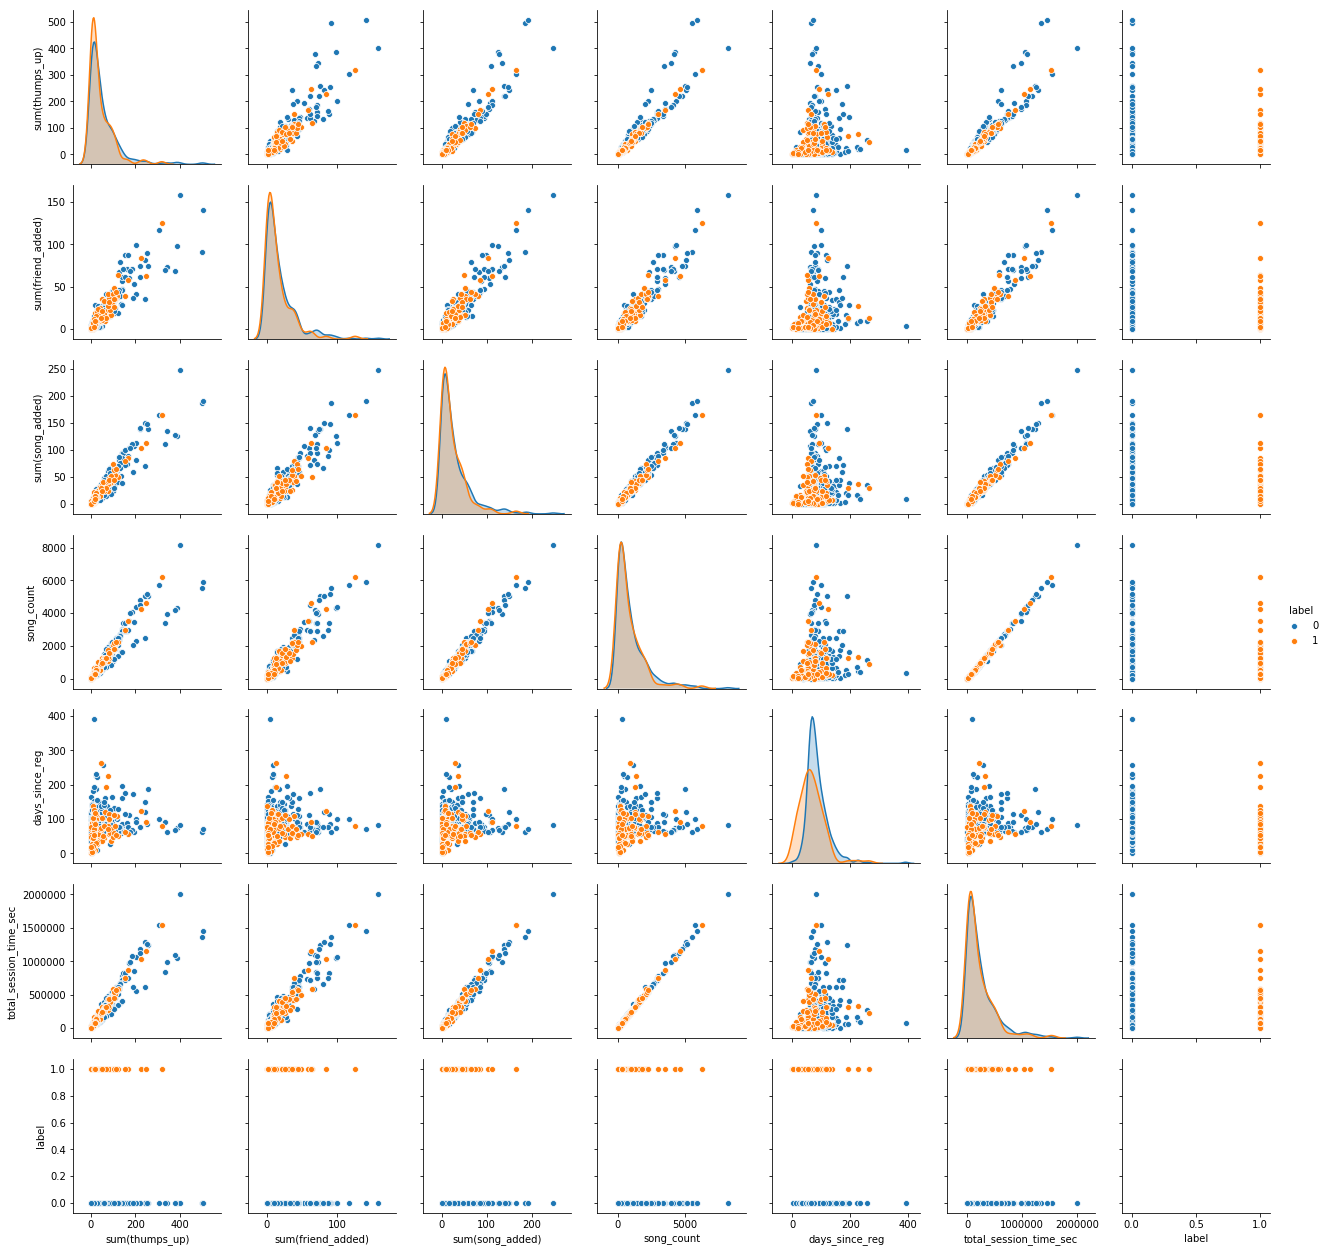

In [28]:
# show relationship between variables for all features
plt.figure(figsize=(25, 25))
sns.pairplot(first_features_df, hue="label");

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 1800x1800 with 0 Axes>

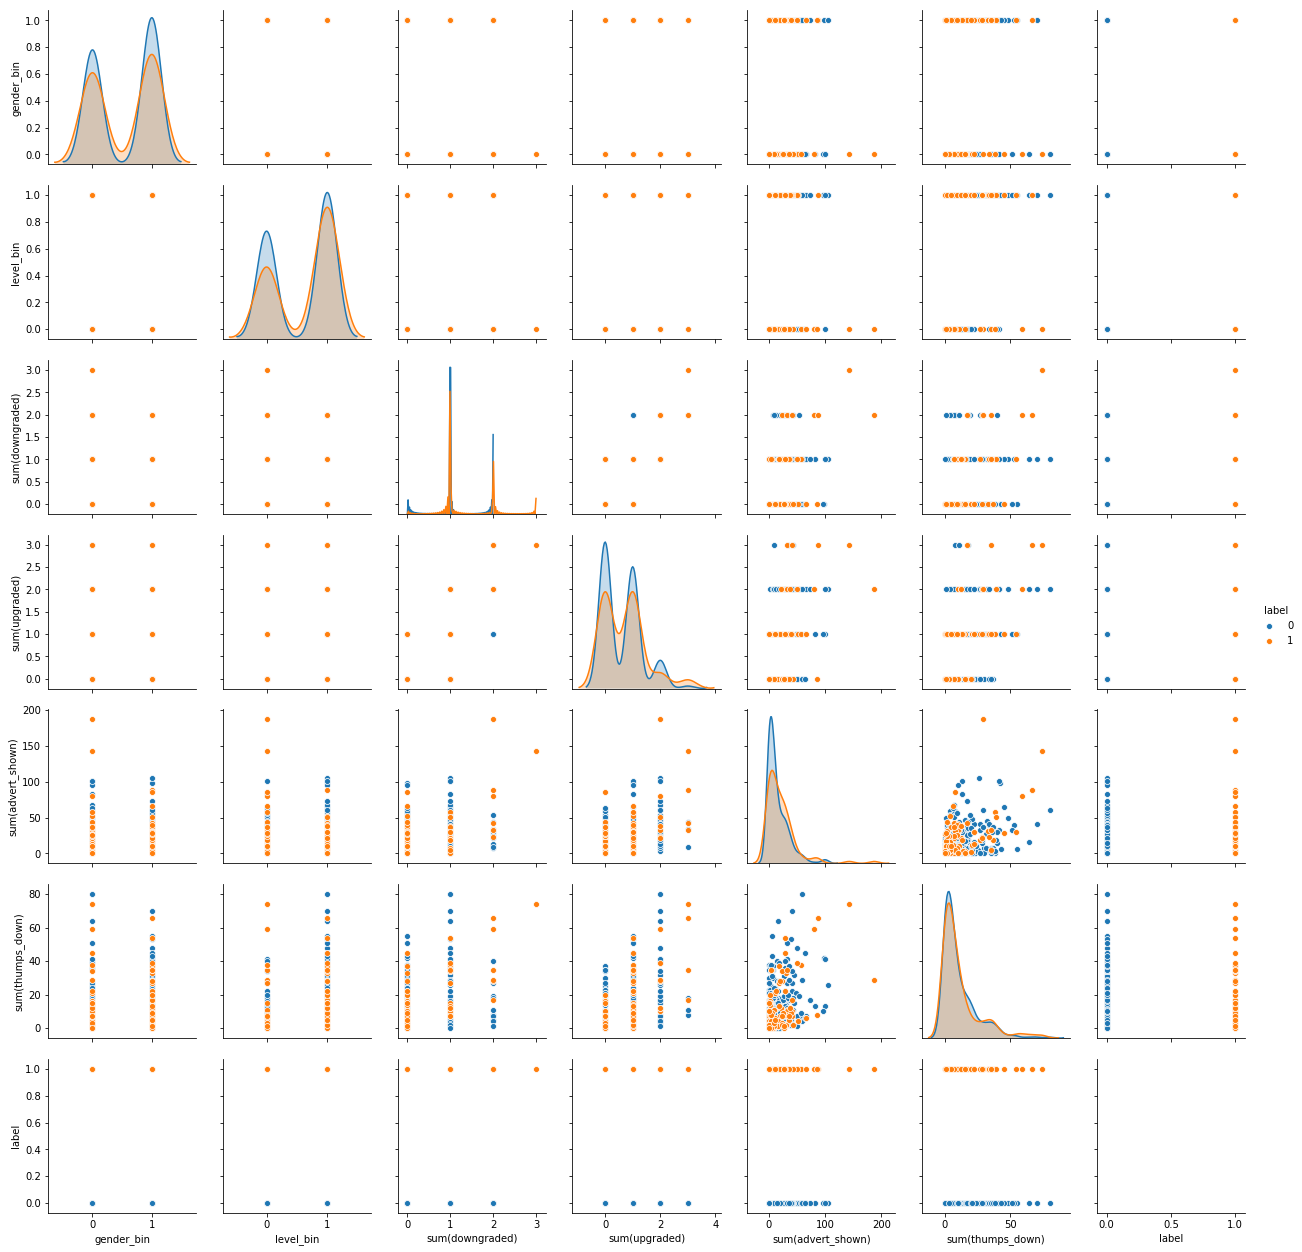

In [29]:
# show relationship between variables for all features
plt.figure(figsize=(25, 25))
sns.pairplot(second_features_df, hue="label");

## Heat map on feature and label correlation

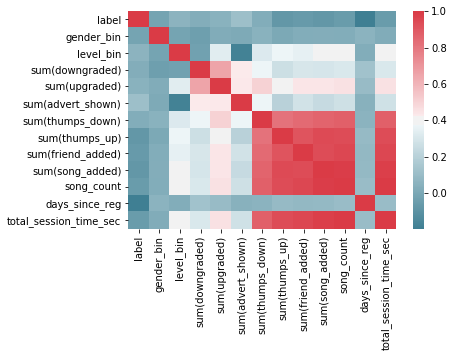

In [30]:
# print correlation between variables
corr = pd_features_df.drop("userId", axis=1).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True));

### Save model to csv to avoid long loading times for further model tuning ###

In [31]:
# save to csv 
#project.save_data("features_unscaled_pd_df.csv", features_df.toPandas().to_csv(), overwrite = True)

In [32]:
# load data from csv
#features_df = spark.read\
#  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
#  .option('header', 'true')\
#  .option("inferSchema", "true")\
#  .load(cos.url('features_unscaled_pd_df.csv', 'sparkify-donotdelete-pr-2exnp1jnopynlt'))
#features_df.take(3)

# Feature Selection

## Feature scaling and vectorization

### Vectorize and scale non-binary features
* Vectorization via VectorAssembler
* Scaling via MinMaxScaler
* user Pipeline to combine both in the transformation process

In [33]:
nonbinary_feature_list = [
 'sum(downgraded)',
 'sum(upgraded)',
 'sum(advert_shown)',
 'sum(thumps_down)',
 'sum(thumps_up)',
 'sum(friend_added)',
 'sum(song_added)',
 'song_count',
 'days_since_reg',
 'total_session_time_sec']

convert_vector_to_double = F.udf(lambda vector_value: round(float(list(vector_value)[0]),3), DoubleType())

for column in nonbinary_feature_list:
    # convert column to vector via VectorAssembler
    assembler = VectorAssembler(inputCols=[column], outputCol=column+"_vect")
    # Scale vectorized column
    scaler = MinMaxScaler(inputCol=column+"_vect", outputCol=column+"_scaled")
    # create Pipeline with assembler and scaler
    pipeline = Pipeline(stages=[assembler, scaler])
    # apply pipeline on features_df Dataframe
    features_df = pipeline.fit(features_df).transform(features_df) \
    .withColumn(column+"_scaled", convert_vector_to_double(column+"_scaled")).drop(column+"_vect")

### Merge scaled features to one feature vector

In [34]:
# create feature list that shall be merged in on vector
feature_list = features_df.schema.names
# remove columns userId, label and all items in nonbinary_feature_list
remove_features_list= nonbinary_feature_list + ["userId", "label"]
feature_list = [item for item in feature_list if item not in remove_features_list]
# assemble features in feature_list to one vector using VectorAssembler
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
features_df = assembler.transform(features_df)

## Perform PCA to select relevant features

In [35]:
pca_number = 3
pca = PCA(k=pca_number, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features_df.select("features"))
pca_features = model.transform(features_df.select("features")).select("pcaFeatures")

# join column "pcaFeatures" to existing dataframe
pca_features = pca_features.withColumn("id", F.monotonically_increasing_id())
features_df = features_df.withColumn("id", F.monotonically_increasing_id())
features_df = features_df.join(pca_features, "id", "outer").drop("id")

print("Explained variance by {} principal components: {:.2f}%".format(pca_number, sum(model.explainedVariance)*100))

Explained variance by 3 principal components: 88.20%


## Save features as csv to avoid long loading times

In [36]:
# save to csv 
#features_df.toPandas().to_csv("features_pd_df.csv")
#project.save_data("features_pd_df.csv", features_df.toPandas().to_csv(), overwrite = True)

In [37]:
# load data from csv
#features_df = spark.read.load("features_pd_df.csv", format="csv", inferSchema="true", header="true")
#features_df = spark.read\
#  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
#  .option('header', 'true')\
#  .option("inferSchema", "true")\
#  .load(cos.url('features_pd_df.csv', 'sparkify-donotdelete-pr-2exnp1jnopynlt'))
#features_df.take(3)

# Modeling

## Split in training, test, validation set

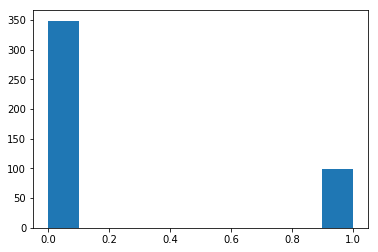

In [38]:
train, test = features_df.randomSplit([0.8, 0.2], seed=42)

plt.hist(features_df.toPandas()['label'])
plt.show()

## Analyze label class imbalance

In [39]:
# calculate balancing ratio to account for class imbalance
balancing_ratio = train.filter(train['label']==0).count()/train.count()
train=train.withColumn("classWeights", F.when(train.label == 1,balancing_ratio).otherwise(1-balancing_ratio))

## Machine Learning Model Selection and Tuning

 * Model learning problem category: supervised learning, logistic regression
 * ML estimators from pyspark.ml:
     * LogisticRegression
 * ML hyperparameters in estimators (for grid search/ tuning):
     * LogisticRegression(maxIter=..., regParam=..., elasticNetParam=...)
 * ML evaluators from pyspark.ml:
     * BinaryClassificationEvaluator

In [40]:
# Create a logistic regression object
lr_simple = LogisticRegression(featuresCol = 'pcaFeatures', labelCol = 'label', weightCol="classWeights")

In [41]:
# fit training data to lr model and check performance before further refinement
lr_simple_model = lr_simple.fit(train)
training_summary = lr_simple_model.summary

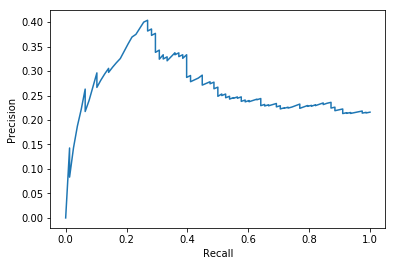

In [42]:
# print precision and recall
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [43]:
# function that evaluates model prediction
def evaluate_prediction(df):
    '''
    ARGS: Spark Dateframe with columns "label" and "prediction"
    
    OUTPUT: F1_score, recall, prediction as float variables
    
    Function that prints F1 score, recall and prediction
    '''
    # evaluate results
    pd_pred = df.toPandas()

    # calculate score for f1, precision, recall
    f1 = f1_score(pd_pred.label, pd_pred.prediction)
    recall = recall_score(pd_pred.label, pd_pred.prediction)
    precision = precision_score(pd_pred.label, pd_pred.prediction)

    print("F1 Score: {:.2f}, Recall: {:.2f}, Precision: {:.2f}".format(f1, recall, precision))
    
    return f1, recall, precision

In [44]:
# transform testing data and check results
simple_pred = lr_simple_model.transform(test)
evaluate_prediction(simple_pred)

F1 Score: 0.30, Recall: 0.43, Precision: 0.23


(0.3, 0.42857142857142855, 0.23076923076923078)

In [78]:
lr_simple_model.extractParamMap()

{Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', name='featuresCol', doc='features column name'): 'pcaFeatures',
 Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_4d89a2ae9a7723a9d3b6', n

In [65]:
# Create a logistic regression object
lr = LogisticRegression(featuresCol = 'pcaFeatures', labelCol = 'label', weightCol="classWeights")

In [66]:
# create evaluator
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR')

# tune model via CrossValidator and parameter Grid 
# build paramGrid
lr_paramGrid = (ParamGridBuilder() \
    .addGrid(lr.maxIter, [1, 10, 100]) \
    .addGrid(lr.regParam,[0.0, 0.5, 2.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build())

# build cross validator
lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [67]:
# run cross validation
# train model on train data
lr_crossval_model = lr_crossval.fit(train)

In [48]:
# wait for 15 min = 900 seconds to avoid bug with prediction from trained spark model
time.sleep(900)

## Model Evaluation

* use scikit learn metrics f1, precision, recall for model evaluation

In [70]:
# predict on test data
lr_crossval_pred = lr_crossval_model.transform(test)

In [71]:
evaluate_prediction(lr_crossval_pred)

F1 Score: 0.37, Recall: 0.62, Precision: 0.27


(0.37142857142857144, 0.6190476190476191, 0.2653061224489796)

# Check Decision Tree as alternative estimator

In [51]:
# Create a decision tree estimator object
dt = DecisionTreeClassifier(featuresCol = 'pcaFeatures', labelCol = 'label')

In [52]:
# fit training data to lr model and check performance before further refinement
dt_simple_model = dt.fit(train)
#dt_training_summary = dt_model.summary

In [53]:
# transform testing data and check results
dt_simple_pred = dt_simple_model.transform(test)
evaluate_prediction(dt_simple_pred)

F1 Score: 0.40, Recall: 0.29, Precision: 0.67


(0.4, 0.2857142857142857, 0.6666666666666666)

In [68]:
# get parameters of simple model
dt_simple_model.extractParamMap()

{Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='featuresCol', doc='features column name'): 'pcaFeatures',
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name

In [69]:
# tune dt model via CrossValidator and parameter Grid 
# build paramGrid
dt_paramGrid = (ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 8]) \
    .addGrid(dt.maxBins,[20, 32, 50]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build())

# build cross validator
dt_crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps= dt_paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# run cross validation
# train model on train data
dt_crossval_model = dt_crossval.fit(train)

# wait for 15 min = 900 seconds to avoid bug with prediction from trained spark model
time.sleep(900)

# predict on test data
dt_crossval_pred = dt_crossval_model.transform(test)

#evaluate prediction results
evaluate_prediction(dt_crossval_pred)

F1 Score: 0.25, Recall: 0.14, Precision: 1.00


(0.25, 0.14285714285714285, 1.0)

## Get best model parameters ##
### Linear regression model parameters after tuning ###

In [72]:
list(zip(lr_crossval_model.avgMetrics, lr_paramGrid))

[(0.2258063798871866,
  {Param(parent='LogisticRegression_4a73acf1913266c719e1', name='maxIter', doc='max number of iterations (>= 0).'): 1,
   Param(parent='LogisticRegression_4a73acf1913266c719e1', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_4a73acf1913266c719e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.2258063798871866,
  {Param(parent='LogisticRegression_4a73acf1913266c719e1', name='maxIter', doc='max number of iterations (>= 0).'): 1,
   Param(parent='LogisticRegression_4a73acf1913266c719e1', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_4a73acf1913266c719e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}),
 (0.225806379887

In [73]:
best_lr_params = lr_crossval_model.bestModel.extractParamMap()

In [74]:
best_lr_params

{Param(parent='LogisticRegression_4a73acf1913266c719e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_4a73acf1913266c719e1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_4a73acf1913266c719e1', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_4a73acf1913266c719e1', name='featuresCol', doc='features column name'): 'pcaFeatures',
 Param(parent='LogisticRegression_4a73acf1913266c719e1', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_4a73acf1913266c719e1', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_4a73acf1913266c719e1', n

### Decision tree model parameters after tuning ###

In [75]:
list(zip(dt_crossval_model.avgMetrics, dt_paramGrid))

[(0.21209681713579853,
  {Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
   Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}),
 (0.20974292726182026,
  {Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='maxBins', doc='Max number of bins for discretizing continuou

In [76]:
best_dt_params = dt_crossval_model.bestModel.extractParamMap()

In [77]:
best_dt_params

{Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='featuresCol', doc='features column name'): 'pcaFeatures',
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy',
 Param(parent='DecisionTreeClassifier_42149583c31f07072aef', n

In [61]:
end_time = datetime.datetime.now()

In [62]:
print("start of notebook run at: ", str(start_time))
print("end of notebook run at: ", str(end_time))

start of notebook run at:  2019-12-29 14:24:33.835321
end of notebook run at:  2019-12-29 16:40:41.657971


## Save models to avoid long loading times ##